In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix, f1_score

from lightgbm import LGBMClassifier

In [2]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [4]:
base_features = ['Unnamed0', 'reg1', 'reg2', 'reg3', 'reg4',
       'home', 'chld', 'hinc', 'genf', 'wrat', 'avhv','incm', 'inca', 'plow', 'npro',
       'tgif', 'lgif', 'rgif', 'tdon', 'tlag', 'agif']

In [5]:
df_train = pd.read_csv('Real_Train_chr_data.csv')
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
df_balanced = balance_df_by_target(df_train, 'donr')

In [7]:
X = df_balanced.drop('donr', axis=1)
y = df_balanced[['ID', 'donr']]
 
X.set_index('ID', inplace=True)
y.set_index('ID', inplace=True)

In [8]:
X_final = pd.read_csv('Real_Test_chr_data.csv')
X_final= X_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_final.set_index('ID', inplace=True)
final_index_list = X_final.index

In [9]:
X_final.describe()

,Unnamed0,reg1,reg2,reg3,reg4,home,chld,hinc,genf,wrat,...,incm,inca,plow,npro,tgif,lgif,rgif,tdon,tlag,agif
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,...,1801.000000,1801.000000,1801.00000,1801.000000,1801.000000,1801.000000,1801.00000,1801.000000,1801.000000,1801.000000
mean,1654.053304,0.207107,0.348140,0.121599,0.127152,0.875625,1.595225,3.930039,0.605219,7.077179,...,44.272071,56.975014,13.86452,61.239311,115.318712,22.667407,15.53859,18.636313,6.363687,11.564192
std,1106.927999,0.405346,0.476513,0.326913,0.333235,0.330101,1.417337,1.395864,0.488939,2.274774,...,25.749053,25.759873,12.97020,30.312904,85.934572,26.055515,12.32332,5.500343,3.716538,6.350623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,14.000000,0.00000,2.000000,25.000000,3.000000,1.00000,5.000000,2.000000,2.130000
25%,731.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,6.000000,...,27.000000,40.000000,4.00000,36.000000,64.000000,10.000000,7.00000,15.000000,4.000000,6.960000
50%,1496.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,1.000000,8.000000,...,38.000000,51.000000,10.00000,60.000000,91.000000,16.000000,12.00000,18.000000,5.000000,10.130000
75%,2486.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,5.000000,1.000000,9.000000,...,55.000000,68.000000,20.00000,84.000000,144.000000,25.000000,20.00000,21.000000,7.000000,14.540000
max,3973.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,7.000000,1.000000,9.000000,...,287.000000,287.000000,70.00000,154.000000,1940.000000,389.000000,163.00000,40.000000,34.000000,51.390000


In [10]:
X.head(10)

,Unnamed0,reg1,reg2,reg3,reg4,home,chld,hinc,genf,wrat,...,incm,inca,plow,npro,tgif,lgif,rgif,tdon,tlag,agif
ID,,,,,,,,,,,,,,,,,,,,,
3357,1707,0,0,0,1,1,0,3,0,0,...,15,27,46,34,73,31,16,34,3,9.46
6541,3281,0,0,0,0,1,0,4,1,2,...,31,37,14,34,53,21,27,19,7,14.98
3803,965,0,1,0,0,1,3,4,0,9,...,37,37,22,66,198,8,8,15,3,6.24
4034,2033,0,0,0,1,1,0,2,1,8,...,14,53,21,82,154,27,18,14,3,13.53
7380,3687,1,0,0,0,1,2,1,0,1,...,44,47,11,51,77,14,9,16,3,8.26
2650,668,0,0,0,1,0,3,2,0,2,...,47,47,11,102,223,5,5,23,4,4.08
4612,2304,0,1,0,0,1,1,4,1,4,...,34,34,16,53,57,4,6,15,6,4.60
137,40,0,0,0,0,1,0,4,0,9,...,36,40,28,81,96,10,6,19,3,7.76
1082,519,0,0,0,1,0,2,1,0,8,...,40,58,5,89,134,22,19,14,20,13.50


          Unnamed0      reg1      reg2      reg3      reg4      home  \
Unnamed0  1.000000 -0.013166  0.008020 -0.005356  0.015779  0.003427   
reg1     -0.013166  1.000000 -0.363011 -0.185071 -0.196683  0.000627   
reg2      0.008020 -0.363011  1.000000 -0.270419 -0.287386  0.015165   
reg3     -0.005356 -0.185071 -0.270419  1.000000 -0.146516 -0.011988   
reg4      0.015779 -0.196683 -0.287386 -0.146516  1.000000  0.004844   
home      0.003427  0.000627  0.015165 -0.011988  0.004844  1.000000   
chld     -0.007654 -0.051646  0.003107 -0.016958  0.023828 -0.095066   
hinc      0.014265 -0.001800  0.006475 -0.025929  0.001656  0.010875   
genf     -0.008587  0.012166  0.009674 -0.010361  0.010516 -0.008402   
wrat      0.025289 -0.026338  0.043556 -0.004338 -0.050343  0.061323   
avhv      0.013003  0.015903  0.000537 -0.001258 -0.023644  0.056803   
incm      0.017829  0.010665  0.001225 -0.016453 -0.019333  0.047634   
inca      0.011926  0.017540  0.000583 -0.009417 -0.026139  0.04

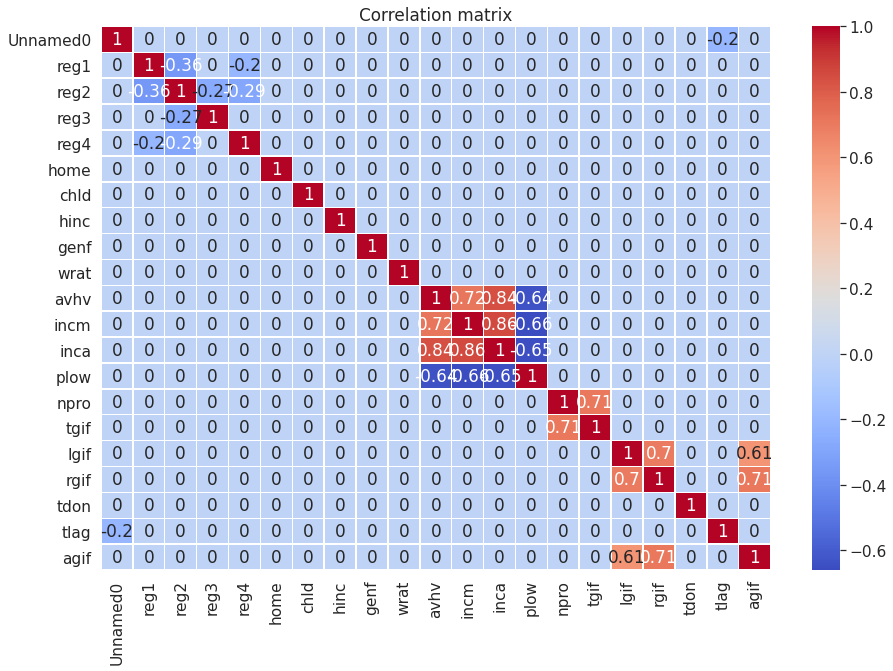

In [11]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [12]:
X['gpr'] = X['tgif']/X['npro']
X_final['gpr'] = X_final['tgif'] / X_final['npro']

In [13]:
X['hch'] = X['hinc']/X['chld']
X_final['hch'] = X_final['hinc'] / X_final['chld']

In [14]:
X['hicm'] = X['hinc']/X['incm']
X_final['hicm'] = X_final['hinc'] / X_final['incm']

In [15]:
X['rl'] = X['rgif']/X['lgif']
X_final['rl'] = X_final['rgif'] / X_final['lgif']

Check

In [16]:
remain_features = ['Unnamed0', 'reg1', 'reg2', 'reg3', 'reg4',
       'home', 'chld', 'hinc', 'wrat', 'avhv', 'inca', 'plow', 'npro',
       'tgif', 'lgif', 'rgif', 'tdon', 'tlag', 'agif', 'gpr', 'hch', 'hicm', 'rl']
X = X[remain_features]
X_final = X_final[remain_features]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
model = LGBMClassifier(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMClassifier(max_depth=15, min_samples_leaf=5, n_estimators=250,
               random_state=42)

In [19]:
y_pred= model.predict(X_test)

In [20]:
confusion_matrix(y_test['donr'], y_pred)

array([[567,  68],
       [ 47, 579]])

In [21]:
f1_score(y_test['donr'], y_pred)

0.9096622152395915

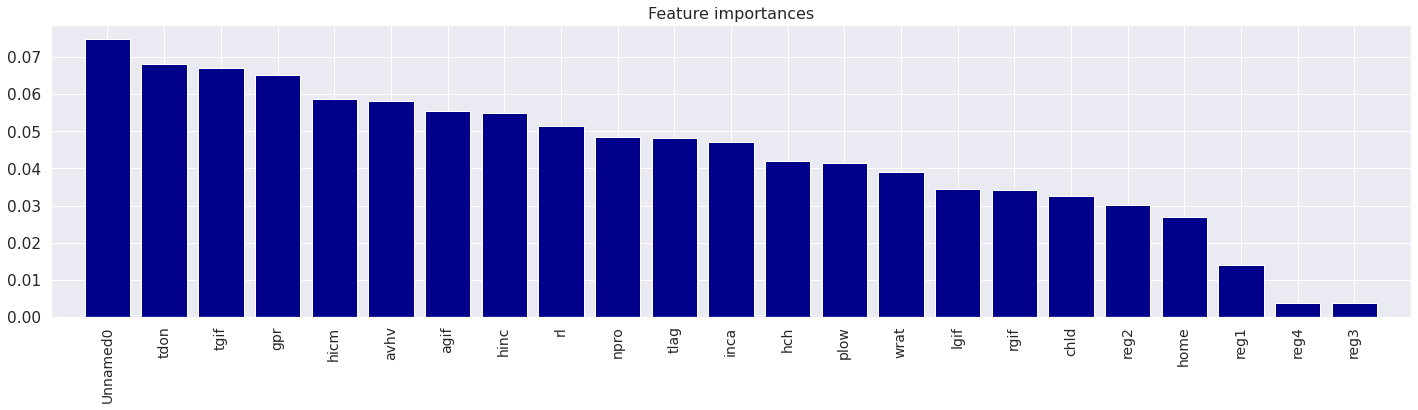

In [22]:
plot_feature_importances(importances = model.feature_importances_, X=X)

Final Output

In [24]:
fin_mod = LGBMClassifier(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
fin_mod.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMClassifier(max_depth=15, min_samples_leaf=5, n_estimators=250,
               random_state=42)

In [25]:
y_fin = fin_mod.predict(X_final)

In [26]:
y_fin_df = pd.DataFrame(y_fin, columns=['donr'])

In [27]:
y_fin_df

,donr
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
1796,1.0
1797,0.0
1798,1.0
1799,0.0


In [28]:
filename = '201220_Egorov_1.csv'
y_fin_df.to_csv(filename, index=None)